In [1]:
# Gain modulation RNN with oja learning on weight matrix
import numpy as np
import sys
sys.path.append("..")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
from torch import tensor
import seaborn as sns
import torch.nn as nn

In [2]:
period = 120
time_constant = 100 #ms
timestep = 10 #ms
num_inputs = 1
num_nodes = 32

In [ ]:
# find the correct weights sum under perturbation
simu_epochs = 10000
ndata = simu_epochs * period
time = ndata * timestep

# define inputs and targets
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)
inputs += 0.1  # perturbation

# initialize
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = [1]*excite_num + [-1]*(num_nodes-excite_num)
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)
# Initializing matrix
np.random.seed(1)
connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(size=(num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
input_weight_matrix = np.random.normal(0, 1/np.sqrt(num_inputs), (num_inputs, num_nodes)) # useless
init_activations = np.zeros((num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))
output_weight_matrix = np.ones((1, num_nodes))
# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type
init_weight_matrix = weight_matrix.copy()

# training
backprop_lr = 0.1
loss_func = nn.MSELoss()
has_backprop = False
simu_losses = []
simu_outputs = []
last_epoch_loss = 0

for epoch in range(simu_epochs):

    # skip first epoch
    if epoch > 0 and has_backprop == False:
        has_backprop = True
        print('backprop start!!!')

    # record
    epoch_losses = []

    # go through one period
    for idx in range(period):
        i = epoch * period + idx  # index of data
        
        # Creating RNN
        network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                    time_constant=time_constant, timestep=timestep)
        
        # forward
        this_input = inputs[i].item()
        this_output = network.forward(this_input).squeeze()
        this_activations = network.activation.clone()

        # get loss
        this_target = tensor(targets[i].item())
        loss_val = loss_func(this_output, this_target)

        # backprop
        if has_backprop:
            opt = torch.optim.SGD([network.weight_matrix], lr=backprop_lr)
            loss_val.backward()
            opt.step()
            opt.zero_grad()
        # weight boundary
        network.weight_matrix = network.weight_matrix * network.connectivity_matrix
        network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
        # update init weights
        weight_matrix = network.weight_matrix.detach().numpy()

        # update activations
        last_activations = this_activations.clone() # for hebbian
        init_activations = this_activations.detach().numpy()

        # record
        epoch_losses.append(loss_val.item())
        simu_outputs.append(this_output.item())

    # epoch mean
    mean_epoch_loss = np.mean(epoch_losses)
    simu_losses.append(mean_epoch_loss)
    last_epoch_loss = mean_epoch_loss.copy()

    # print
    if epoch % 20 == 0:
        excite_weight_sum = np.sum(weight_matrix * (weight_type > 0))
        inhibit_weight_sum = np.sum(weight_matrix * (weight_type < 0))
        print(f'Epoch {epoch+1}, Loss: {mean_epoch_loss}\n\
                Excite weight sum: {excite_weight_sum}, Inhibit weight sum: {inhibit_weight_sum}')

Epoch 1, Loss: 3.7488150253891943
                Excite weight sum: 401.10858154296875, Inhibit weight sum: -381.28363037109375
backprop start!!!
Epoch 21, Loss: 0.02075132808926862
                Excite weight sum: 401.613525390625, Inhibit weight sum: -381.1929626464844
Epoch 41, Loss: 0.024198679214557237
                Excite weight sum: 402.4818420410156, Inhibit weight sum: -380.910400390625
Epoch 61, Loss: 0.026354947993490897
                Excite weight sum: 404.24407958984375, Inhibit weight sum: -379.5708312988281
Epoch 81, Loss: 0.02617993240260148
                Excite weight sum: 406.46051025390625, Inhibit weight sum: -377.58721923828125
Epoch 101, Loss: 0.024237715428924625
                Excite weight sum: 408.84674072265625, Inhibit weight sum: -375.511962890625
Epoch 121, Loss: 0.02040792629445131
                Excite weight sum: 410.87945556640625, Inhibit weight sum: -373.85235595703125
Epoch 141, Loss: 0.01660346562664851
                Excite weight sum:

## Loading Trained Weights

In [3]:
with open('../weights/SIN2_bphebbpt_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [4]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'gain_changes', 'shift_changes', 'init_weight', 'init_activations'])

In [14]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
gain_changes = np.array(weight_history['gain_changes'])
shift_changes = np.array(weight_history['shift_changes'])
init_weight_matrix = np.array(weight_history['init_weight'])
# weights = weight_history['weights']
init_activations = np.array(weight_history['init_activations'])

## 10000 epochs

In [15]:
simu_epochs = 20000
ndata = simu_epochs * period
time = ndata * timestep

# define inputs and targets
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# define noise
perturb_start = 50
perturb_last = 10000
inputs[perturb_start*period:(perturb_start+perturb_last)*period] += 0.1

In [ ]:
backprop_lr = 0.01
loss_func = nn.MSELoss()
has_perturb = False
has_hebbian = False
has_backprop = True
hebbian_lr = 0.000001
max_hebbian_lr = 0.000001
hebbian_up_rate = max_hebbian_lr / 200
hebb_alpha_ext = 415
hebb_alpha_inh = 375

init_gain = gains.copy()
init_shift = shifts.copy()
# init_activations = np.zeros((num_nodes, 1))
theo_gain = np.ones((num_nodes, 1))
theo_shift = np.zeros((num_nodes, 1))

simu_losses = []
gain_changes = []
shift_changes = []
simu_outputs = []
last_epoch_loss = 0

for epoch in range(simu_epochs):

    if epoch == perturb_start:
        has_perturb = True
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation start!!!")
    if epoch == perturb_start + perturb_last:
        has_perturb = False
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation end!!!")

    # start hebbian and shrinkage
    if has_perturb and epoch > perturb_start + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("perturb learning start!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("origin learning start!!!")

    # update hebbian learning rate, once per epoch
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_up_rate

    # record
    epoch_losses = []
    epoch_gain_changes = []
    epoch_shift_changes = []

    # go through one period
    for idx in range(period):
        i = epoch * period + idx  # index of data
        
        # Creating RNN
        network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                    time_constant=time_constant, timestep=timestep)
        
        # forward
        this_input = inputs[i].item()
        this_output = network.forward(this_input).squeeze()
        this_activations = network.activation.clone()

        # get loss
        this_target = tensor(targets[i].item())
        loss_val = loss_func(this_output, this_target)

        # backprop
        if has_backprop:
            opt = torch.optim.SGD([network.gain, network.shift], lr=backprop_lr)
            loss_val.backward()
            opt.step()
            opt.zero_grad()
        init_gain = network.gain.detach().numpy()
        init_shift = network.shift.detach().numpy()
        # gain_change = np.linalg.norm(init_gain - gains, 2)
        # shift_change = np.linalg.norm(init_shift - shifts, 2)
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # update weights by hebbian learning
        if has_hebbian:
            # Calculate Hebbian weight updates
            hebbian_update = torch.matmul(last_activations, this_activations.T)
            hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
            # Normalized Hebbian learning
            network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
            tmp_weights_ext = network.weight_matrix[network.weight_type]
            tmp_weights_inh = network.weight_matrix[~network.weight_type]
            network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
            network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
            # weight boundary
            network.weight_matrix = network.weight_matrix * network.connectivity_matrix
            network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
        # update init weights
        weight_matrix = network.weight_matrix.detach().numpy()

        # update activations
        last_activations = this_activations.clone() # for hebbian
        init_activations = this_activations.detach().numpy()

        # record
        epoch_losses.append(loss_val.item())
        epoch_gain_changes.append(gain_change)
        epoch_shift_changes.append(shift_change)
        simu_outputs.append(this_output.item())

    # epoch mean
    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_gain_change = np.mean(epoch_gain_changes)
    mean_epoch_shift_change = np.mean(epoch_shift_changes)
    simu_losses.append(mean_epoch_loss)
    gain_changes.append(mean_epoch_gain_change)
    shift_changes.append(mean_epoch_shift_change)
    last_epoch_loss = mean_epoch_loss.copy()

    # print
    if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{simu_epochs}, Loss: {mean_epoch_loss}, GC:{mean_epoch_gain_change},SC:{mean_epoch_shift_change}')

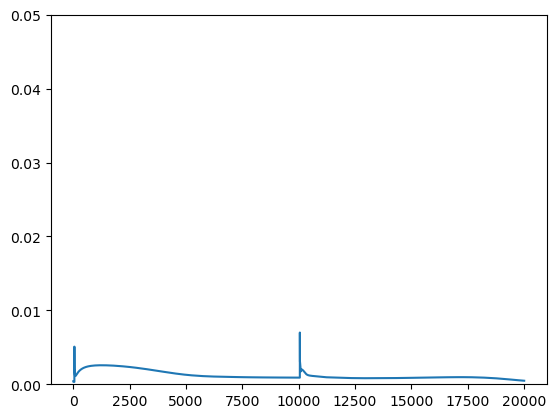

In [242]:
plt.plot(simu_losses)
plt.ylim([0, 0.05])
plt.show()

In [172]:
# plt.subplots(figsize=(10, 5))
# plt.plot(time_points, targets, label='targets')
# plt.plot(time_points, simu_outputs, label='outputs')
# plt.legend()
# plt.show()

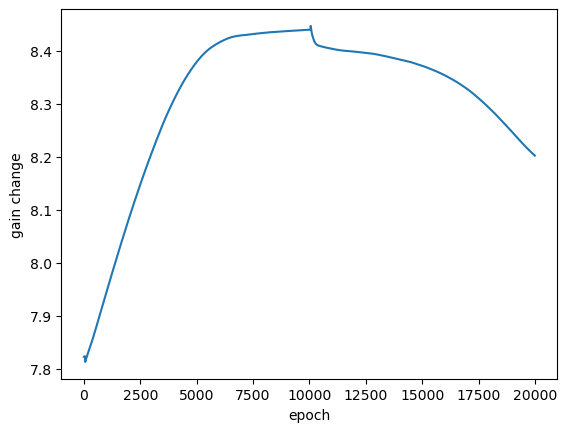

In [239]:
plt.plot(np.arange(len(gain_changes)), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

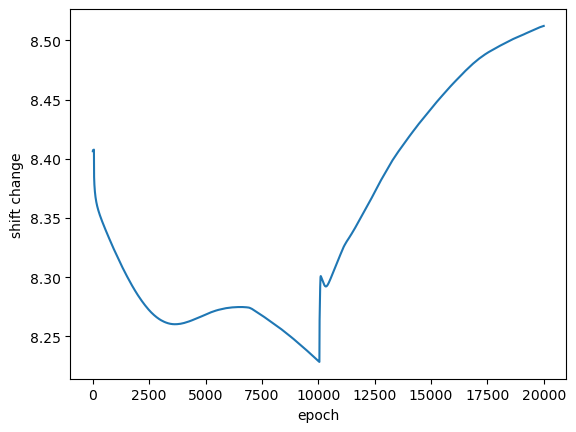

In [240]:
plt.plot(np.arange(len(shift_changes)), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

## Different Lasting

In [17]:
simu_epochs = 20000
ndata = simu_epochs * period
time = ndata * timestep
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)

# define noise
perturb_start = 50
perturb_lasts = [2000, 5000, 10000]

# record
all_simu_losses = []
all_gain_changes = []
all_shift_changes = []

for perturb_last in perturb_lasts:

    print(f"perturb_last: {perturb_last}")

    # define inputs and targets
    inputs = (1 + np.sin(time_points/60*np.pi))/2
    targets = (1 + np.sin((time_points+1)/60*np.pi))/2
    inputs = inputs.reshape(-1, 1)
    targets = targets.reshape(-1, 1)
    inputs[perturb_start*period:(perturb_start+perturb_last)*period] += 0.1

    # init
    backprop_lr = 0.01
    loss_func = nn.MSELoss()
    has_perturb = False
    has_hebbian = False
    has_backprop = True
    hebbian_lr = 0.000001
    max_hebbian_lr = 0.000001
    hebbian_up_rate = max_hebbian_lr / 200
    hebb_alpha_ext = 415
    hebb_alpha_inh = 375
    init_gain = gains.copy()
    init_shift = shifts.copy()
    weight_matrix = np.array(weight_history['trained weights'])
    init_activations = np.array(weight_history['init_activations'])
    # init_activations = np.zeros((num_nodes, 1))
    theo_gain = np.ones((num_nodes, 1))
    theo_shift = np.zeros((num_nodes, 1))

    simu_losses = []
    gain_changes = []
    shift_changes = []
    simu_outputs = []
    last_epoch_loss = 0

    for epoch in range(simu_epochs):

        if epoch == perturb_start:
            has_perturb = True
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation start!!!")
        if epoch == perturb_start + perturb_last:
            has_perturb = False
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation end!!!")

        # start hebbian and shrinkage
        if has_perturb and epoch > perturb_start + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("perturb learning start!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("origin learning start!!!")

        # update hebbian learning rate, once per epoch
        if has_hebbian and hebbian_lr < max_hebbian_lr:
            hebbian_lr += hebbian_up_rate

        # record
        epoch_losses = []
        epoch_gain_changes = []
        epoch_shift_changes = []

        # go through one period
        for idx in range(period):
            i = epoch * period + idx  # index of data
            
            # Creating RNN
            network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                        time_constant=time_constant, timestep=timestep)
            
            # forward
            this_input = inputs[i].item()
            this_output = network.forward(this_input).squeeze()
            this_activations = network.activation.clone()

            # get loss
            this_target = tensor(targets[i].item())
            loss_val = loss_func(this_output, this_target)

            # backprop
            if has_backprop:
                opt = torch.optim.SGD([network.gain, network.shift], lr=backprop_lr)
                loss_val.backward()
                opt.step()
                opt.zero_grad()
            init_gain = network.gain.detach().numpy()
            init_shift = network.shift.detach().numpy()
            # gain_change = np.linalg.norm(init_gain - gains, 2)
            # shift_change = np.linalg.norm(init_shift - shifts, 2)
            gain_change = np.linalg.norm(init_gain - theo_gain, 2)
            shift_change = np.linalg.norm(init_shift - theo_shift, 2)

            # update weights by hebbian learning
            if has_hebbian:
                # Calculate Hebbian weight updates
                hebbian_update = torch.matmul(last_activations, this_activations.T)
                hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
                # Normalized Hebbian learning
                network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
                tmp_weights_ext = network.weight_matrix[network.weight_type]
                tmp_weights_inh = network.weight_matrix[~network.weight_type]
                network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
                network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
                # weight boundary
                network.weight_matrix = network.weight_matrix * network.connectivity_matrix
                network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
            # update init weights
            weight_matrix = network.weight_matrix.detach().numpy()

            # update activations
            last_activations = this_activations.clone() # for hebbian
            init_activations = this_activations.detach().numpy()

            # record
            epoch_losses.append(loss_val.item())
            epoch_gain_changes.append(gain_change)
            epoch_shift_changes.append(shift_change)
            simu_outputs.append(this_output.item())

        # epoch mean
        mean_epoch_loss = np.mean(epoch_losses)
        mean_epoch_gain_change = np.mean(epoch_gain_changes)
        mean_epoch_shift_change = np.mean(epoch_shift_changes)
        simu_losses.append(mean_epoch_loss)
        gain_changes.append(mean_epoch_gain_change)
        shift_changes.append(mean_epoch_shift_change)
        last_epoch_loss = mean_epoch_loss.copy()

        # print
        if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{simu_epochs}, Loss: {mean_epoch_loss}, GC:{mean_epoch_gain_change},SC:{mean_epoch_shift_change}')
        
    # record
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)

perturb_last: 2000
Epoch 1/20000, Loss: 0.00040834529253549096, GC:7.822648592019173,SC:8.40633996461124
Epoch 11/20000, Loss: 0.000326047540645528, GC:7.823383161778726,SC:8.40726487475985
Epoch 21/20000, Loss: 0.0003251133579070142, GC:7.823436097798679,SC:8.407367486495941
Epoch 31/20000, Loss: 0.00032432194085825944, GC:7.823473184734977,SC:8.407473165189462
Epoch 41/20000, Loss: 0.0003235845528773614, GC:7.823506310542994,SC:8.407582815612098
perturbation start!!!
Epoch 51/20000, Loss: 0.00509080807575211, GC:7.819929943612349,SC:8.401337324201402
Epoch 61/20000, Loss: 0.0017083646287461582, GC:7.813447430495787,SC:8.38237285479537
Epoch 71/20000, Loss: 0.0012778272941717627, GC:7.815317794407654,SC:8.378040836048234
Epoch 81/20000, Loss: 0.001143521199600439, GC:7.816904646478687,SC:8.375035841755363
Epoch 91/20000, Loss: 0.00111323077317896, GC:7.818306459884472,SC:8.372659841373972
Epoch 101/20000, Loss: 0.0011258500240975966, GC:7.819608647780191,SC:8.370683879405481
Epoch 111

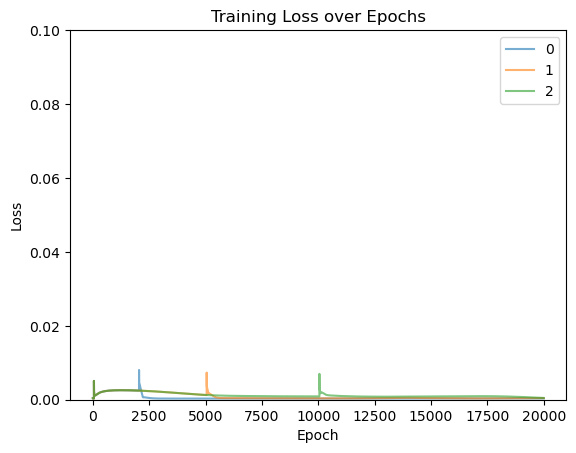

In [18]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=i, alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.1])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.legend()
plt.show()

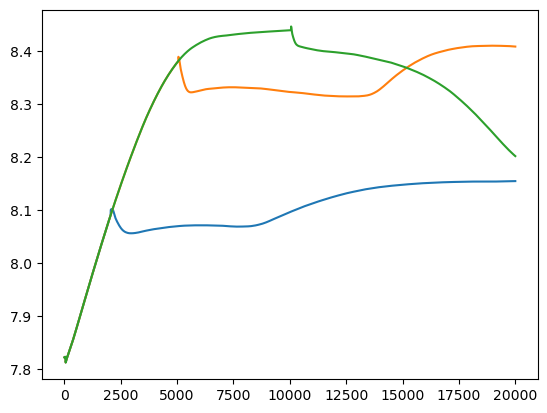

In [19]:
for gain_changes in all_gain_changes:
    plt.plot(np.arange(simu_epochs), gain_changes)

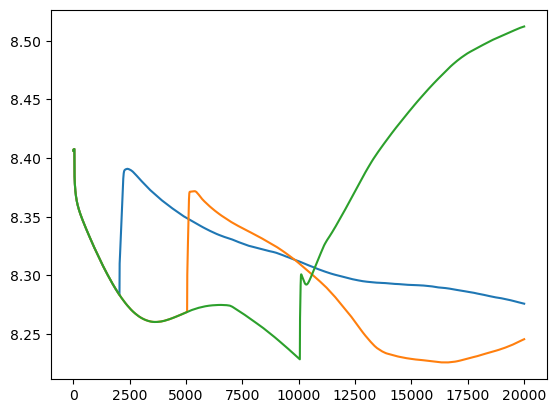

In [20]:
for shift_changes in all_shift_changes:
    plt.plot(np.arange(simu_epochs), shift_changes)